In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

from torchsummary import summary

import matplotlib.pyplot as plt
from hydra import compose, initialize
from omegaconf import OmegaConf

from tqdm import tqdm
import random
import numpy as np

import matplotlib.patches as mpatches
from typing import List, Optional, Tuple

from src.data.bvisa_dm import CS_Dataset
import SimpleITK as sitk

sitk.ProcessObject_SetGlobalWarningDisplay(False)


In [3]:
ds_via11 = CS_Dataset('via11',  'mp2rage_raw',
                'bvisa_CS', dataset_path='',
                preload=False)

In [24]:
ds_bvisa = CS_Dataset('bvisa', 'train', 'skull_stripped', 'central_sulcus',
                 '/mrhome/vladyslavz/git/central-sulcus-analysis/data/brainvisa', False)

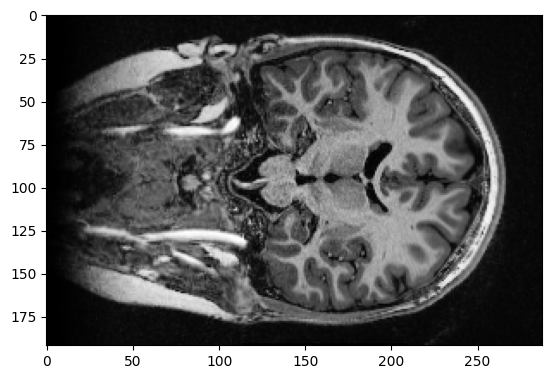

In [48]:
a = sitk.ReadImage(str(ds_via11.img_paths[0][0]))
# a = sitk.DICOMOrient(a, 'RAS')
# a = sitk.DICOMOrient(a, 'PSR')
plt.imshow(sitk.GetArrayFromImage(a)[:, :, 150], cmap='gray')

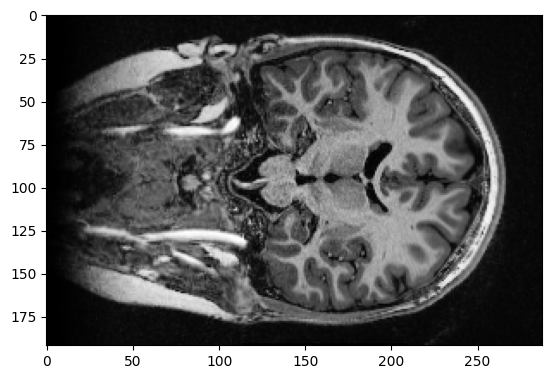

In [47]:
plt.imshow(sitk.GetArrayFromImage(a)[:, :, 150], cmap='gray')

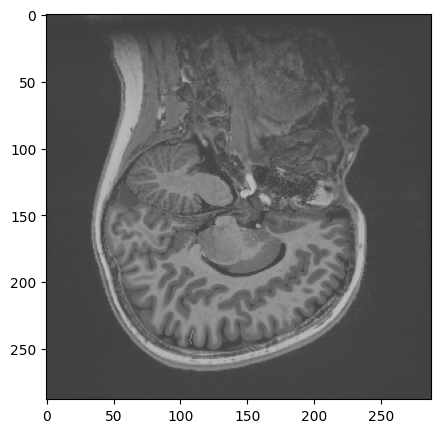

In [20]:
samplevia11 = ds_via11[0]
fig, axs = plt.subplots(1,1, figsize=(5, 5))
s = 110
axs.imshow(samplevia11['target'][:, :, s], alpha=0.5, cmap='gray')
axs.imshow(samplevia11['image'][0, :, :, s], cmap='gray', alpha=0.5)
plt.show()

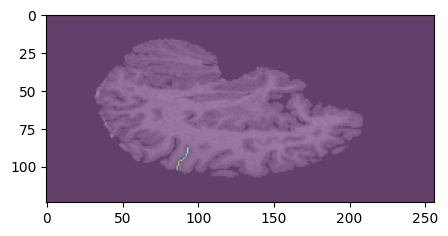

In [21]:
samplebvisa = ds_bvisa[0]
fig, axs = plt.subplots(1,1, figsize=(5, 5))
s = 90
axs.imshow(samplebvisa['image'][0, :, :, s], cmap='gray', alpha=0.5)
axs.imshow(samplebvisa['target'][:, :, s], alpha=0.5)
plt.show()

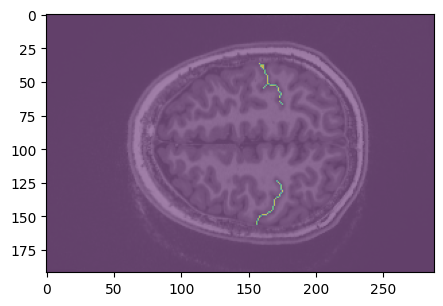

In [87]:
img = sitk.ReadImage(str(ds_via11.img_paths[0][0]))
pred = sitk.ReadImage('/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results/CS1x_synthsegSST_tverskyLoss_monaBasicUnet-freezeEncoder/sub-via010.nii.gz')

pred = sitk.DICOMOrient(pred, 'ASL')

img = sitk.GetArrayFromImage(img)
pred = sitk.GetArrayFromImage(pred)
fig, axs = plt.subplots(1,1, figsize=(5, 5))
s = 220
axs.imshow(img[:, s, :], alpha=0.5, cmap='gray')
axs.imshow(pred[:, s, :], alpha=0.5)
plt.show()

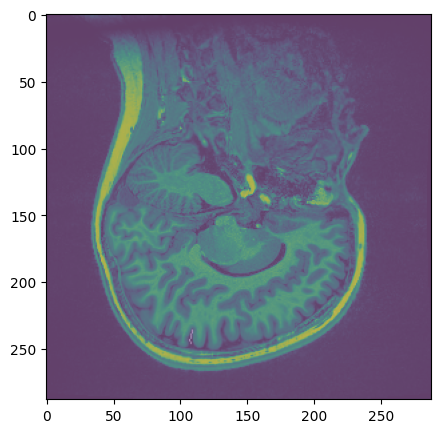

In [51]:
samplevia11 = ds_via11[0]
fig, axs = plt.subplots(1,1, figsize=(5, 5))
s = 110
axs.imshow(samplevia11['target'][:, :, s], alpha=0.5, cmap='gray')
axs.imshow(samplevia11['image'][0, :, :, s], alpha=0.5)
plt.show()

In [4]:
from pathlib import Path
import pyrootutils

# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)


import hydra

import numpy as np
import torch
from omegaconf import  OmegaConf
from pytorch_lightning import LightningModule

from tqdm import tqdm

import src.utils.default as utils
import SimpleITK as sitk
sitk.ProcessObject_SetGlobalWarningDisplay(False)
# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)


# log = utils.get_pylogger(__name__)

torch.set_float32_matmul_precision('medium')
# torch.autograd.set_detect_anomaly(True)

import SimpleITK as sitk

from src.data.bvisa_dm import CS_Dataset

sitk.ProcessObject_SetGlobalWarningDisplay(False)

CHKP = '/mrhome/vladyslavz/git/central-sulcus-analysis/logs_sst/synthseg-monai-BasicUnet-1.5x-half/runs/2023-04-13_16-13-49/checkpoints/epoch-251_val_loss-0.000.ckpt'

out_path = '/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/segm_results'

CHKP = Path(CHKP)
exp_name = CHKP.parent.parent.parent.parent.name
cgf_path = CHKP.parent.parent / '.hydra' / 'config.yaml'
sst_cfg = OmegaConf.load(cgf_path)

sst_model: LightningModule = hydra.utils.instantiate(sst_cfg.model)


sst_model = sst_model.load_from_checkpoint(CHKP).to('cuda')

via11DS = CS_Dataset('via11', 'mp2rage_raw',
                     'bvisa_CS', dataset_path='',
                     preload=False,
                     resample=(1.5, 1.5, 1.5),
                     padd2same_size='171-171-171')

BasicUNet features: (16, 32, 64, 128, 256, 32).
U-Net Embedding dimension: 32000


Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


U-Net Embedding dimension: 32000


In [5]:
sst_cfg.data

{'_target_': 'src.data.self_supervised_dm.ContrastiveDataModule', 'dataset_cfg': {'dataset': 'synthseg', 'nviews': 2, 'skull_strip': 'half', 'resample': [1.5, 1.5, 1.5], 'use_2x2x2_preproc': False}, 'train_batch_size': 3, 'validation_batch_size': 3, 'num_workers': 10}

In [6]:
dm = hydra.utils.instantiate(sst_cfg.data)

2023-04-18 16:10:46,529 - Len of train examples 16 len of validation examples 4


In [7]:
dm.train_dataset[0][0][0].shape

torch.Size([1, 171, 171, 171])

In [8]:
via11DS[0]['image'].shape

torch.Size([1, 171, 171, 171])

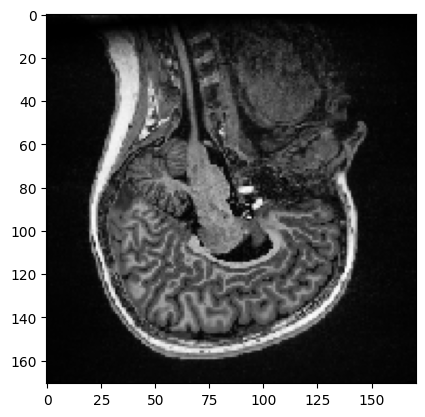

In [10]:
plt.imshow(via11DS[0]['image'][0, :, :, 90], cmap='gray')

In [3]:
from src.data.splits import via11_qc
import nibabel as nib
from tqdm import tqdm

In [9]:
out = Path('/mrhome/vladyslavz/git/central-sulcus-analysis/data/via11/nobackup/fs_segm_maps')

In [14]:
subjs = set(via11_qc['fs_qc_passed']) & set(via11_qc['bvisa_qc_passed'])

In [15]:
for subj in tqdm(subjs):
    s = subj.split('-')[-1]
    aseg = nib.load(f'/mnt/projects/VIA_Vlad/nobackup/MP2RAGE_FS7_1_1/{s}/mri/aseg.mgz')
    nib.save(aseg, out / f'{subj}_aseg.nii.gz')

  0%|          | 0/101 [00:00<?, ?it/s]


FileNotFoundError: No such file or no access: '/mnt/projects/VIA_Vlad/nobackup/MP2RAGE_FS7_1_1/sub-via279/mri/aseg.mgz'